# Introduction
In this notebook, I have done an exporatory data analysis (EDA) on BigQuery's Hacker News dataset using SQL. 

Here a client object is created to connect to the bigquery database and retrive information and run the SQL query. 

The "hacker_news" dataset is contained in BigQuery's public project. Let's jump into it:

## Importing the libraries 

In [1]:
import numpy as np 
import pandas as pd 
from google.cloud import bigquery
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Create a client object
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [3]:
# Create a reference to the "hacker news" dataset
dataset_ref = client.dataset("hacker_news", project = 'bigquery-public-data')

# API request
dataset = client.get_dataset(dataset_ref)

In [4]:
# Lets see the tables in this dataset
tables = list(client.list_tables(dataset))

print("The {} tables in this dataset are: \n".format(len(tables)))

for table in tables:
      print(table.table_id)

The 4 tables in this dataset are: 

comments
full
full_201510
stories


In [5]:
# Fetch the full table
table_ref = dataset_ref.table('full')

full_table = client.get_table(table_ref)

In [6]:
# See the table schema or structure
full_table.schema

[SchemaField('title', 'STRING', 'NULLABLE', 'Story title', (), None),
 SchemaField('url', 'STRING', 'NULLABLE', 'Story url', (), None),
 SchemaField('text', 'STRING', 'NULLABLE', 'Story or comment text', (), None),
 SchemaField('dead', 'BOOLEAN', 'NULLABLE', 'Is dead?', (), None),
 SchemaField('by', 'STRING', 'NULLABLE', "The username of the item's author.", (), None),
 SchemaField('score', 'INTEGER', 'NULLABLE', 'Story score', (), None),
 SchemaField('time', 'INTEGER', 'NULLABLE', 'Unix time', (), None),
 SchemaField('timestamp', 'TIMESTAMP', 'NULLABLE', 'Timestamp for the unix time', (), None),
 SchemaField('type', 'STRING', 'NULLABLE', 'Type of details (comment, comment_ranking, poll, story, job, pollopt)', (), None),
 SchemaField('id', 'INTEGER', 'NULLABLE', "The item's unique id.", (), None),
 SchemaField('parent', 'INTEGER', 'NULLABLE', 'Parent comment ID', (), None),
 SchemaField('descendants', 'INTEGER', 'NULLABLE', 'Number of story or poll descendants', (), None),
 SchemaField

In [7]:
# Lets have a look at the first 10 rows of the table
client.list_rows(full_table, max_results = 10).to_dataframe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  


,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,"I would rather just have wired earbuds, period...",None,zeveb,NaN,1591717736,2020-06-09 15:48:56+00:00,comment,23467666,23456782,NaN,NaN,None
1,None,None,DNS?,None,nly,NaN,1572810465,2019-11-03 19:47:45+00:00,comment,21436112,21435130,NaN,NaN,None
2,None,None,These benchmarks seem pretty good. Filterable...,None,mrkeen,NaN,1591717727,2020-06-09 15:48:47+00:00,comment,23467665,23467426,NaN,NaN,None
3,None,None,Oh really?<p>* Excel alone uses 86.1MB of priv...,None,oceanswave,NaN,1462987532,2016-05-11 17:25:32+00:00,comment,11677248,11676886,NaN,NaN,None
4,None,None,These systems are useless. Of the many flaws:...,None,nyxxie,NaN,1572810473,2019-11-03 19:47:53+00:00,comment,21436113,21435025,NaN,NaN,None
5,None,None,<i>I don&#x27;t worry about the server</i> and...,None,dahfizz,NaN,1566231278,2019-08-19 16:14:38+00:00,comment,20739051,20738305,NaN,NaN,None
6,None,None,Why do you take it as a given that the Secreta...,None,chatmasta,NaN,1425350594,2015-03-03 02:43:14+00:00,comment,9135815,9135800,NaN,NaN,None
7,None,None,Let me know what you guys think so far and if ...,None,augustin1989,NaN,1394076499,2014-03-06 03:28:19+00:00,comment,7351690,7351684,NaN,NaN,None
8,None,None,I often feel that the main result of this priv...,None,jaynetics,NaN,1572810482,2019-11-03 19:48:02+00:00,comment,21436115,21435981,NaN,NaN,None
9,None,None,That is exactly why I generally prefer median-...,None,bugra,NaN,1393290376,2014-02-25 01:06:16+00:00,comment,7294506,7293801,NaN,NaN,None


# Looking at the schema we have following basic questions:
1. Count the content type (stories, comments etc)
2. Number of story authors
3. Average number of story per author
4. Ten  Users/Authors With Most Stories
5. Stories per year from the top 10 authors
6. Authors with highest average score
7. Which date records the most number of stories
8. Stories with most number of comments on 12 Dec 2012

# 1. Count the content type

In [8]:
# Query to count content type
query1 = """
    SELECT type as Content, count(*) as Num_content
    FROM `bigquery-public-data.hacker_news.full` 
    GROUP BY type
    ORDER BY Num_content DESC;
"""

# Set up the query
query_job = client.query(query1)

# API request - run the query, and return a pandas DataFrame
Content_type = query_job.to_dataframe()
print(Content_type)

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


   Content  Num_content
0  comment     28897394
1    story      4691514
2      job        15848
3  pollopt        13843
4     poll         2012


# 2. Number of story authors

In [9]:
# Number of story authors
query2 = """SELECT COUNT(DISTINCT(`by`)) AS Num_Story_Authors
            FROM `bigquery-public-data.hacker_news.full` 
            WHERE type = 'story'
            """
# Set up the query
query_job = client.query(query2)

# API request - run the query, and return a pandas DataFrame
Story_author = query_job.to_dataframe()
print("As of 20th Decmeber 2022, {} different authors have filed stories in Hacker News".format(Story_author.Num_Story_Authors[0]))

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


As of 20th Decmeber 2022, 453344 different authors have filed stories in Hacker News


# 3. Average number of stories per authors

In [10]:
# Average number of stories per authors
query3 = """SELECT COUNT(*)/ COUNT(DISTINCT(`by`)) AS Avg_no_story_per_user
            FROM `bigquery-public-data.hacker_news.full`
            WHERE type = 'story'
            """
# Set up the query
query_job = client.query(query3)

# API request - run the query, and return a pandas DataFrame
Avg_stories= query_job.to_dataframe()
print("On an average each author has filed 10 stories.")

On an average each author has filed 10 stories.


# 4. Ten Users/Authors With Most Stories

In [11]:
# 10 Users/Authors With Most Stories
query4 = """SELECT `by` as Author, COUNT (*) as Num_stories 
    FROM `bigquery-public-data.hacker_news.full` 
    WHERE type = 'story' AND score IS NOT NULL
    GROUP BY Author
    ORDER BY Num_stories DESC
    LIMIT 10
"""
# Set up the query
query_job = client.query(query4)

# API request - run the query, and return a pandas DataFrame
Top_authors = query_job.to_dataframe()
Top_authors

,Author,Num_stories
0,rbanffy,26765
1,Tomte,20647
2,tosh,16081
3,pseudolus,14102
4,jonbaer,13384
5,ingve,12485
6,bookofjoe,9687
7,evo_9,9310
8,prostoalex,9149
9,mooreds,8913


Text(0.5, 0, 'Top Authors')

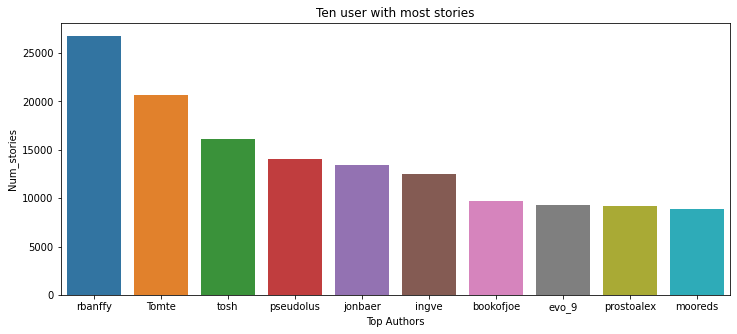

In [12]:
# Lets plot it
plt.figure(figsize=(12,5))
plt.title('Ten user with most stories')
sns.barplot(x = Top_authors.Author, y=Top_authors.Num_stories)
plt.xlabel("Top Authors")

# 5. Stories per year from the top 10 authors

In [13]:
# Stories per year from the top 10 authors
query5 = """WITH Top_authors AS(
          SELECT `by` as Author, COUNT (*) as Num_stories, 
          FROM `bigquery-public-data.hacker_news.full` 
          WHERE type = 'story'
          GROUP BY Author
          ORDER BY Num_stories DESC
          LIMIT 10
        )
        SELECT EXTRACT(YEAR from `timestamp`) as Year, COUNT(*) as Num_stories,
        `by` as Author
        FROM `bigquery-public-data.hacker_news.full` 
        WHERE `by` IN (
          SELECT Author
          FROM Top_authors)
        GROUP BY Year, Author
        ORDER BY Year
"""

# Set up the query
query_job = client.query(query5)

# API request - run the query, and return a pandas DataFrame
Stories_per_year = query_job.to_dataframe()
Stories_per_year

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Year,Num_stories,Author
0,2008,230,rbanffy
1,2009,1304,rbanffy
2,2009,2,prostoalex
3,2010,2892,rbanffy
4,2010,5,prostoalex
...,...,...,...
100,2022,4958,Tomte
101,2022,2082,pseudolus
102,2022,290,jonbaer
103,2022,818,prostoalex


### This representation is quite inconvenient, lets tranform the data into wide format.

In [14]:
wide_dat = pd.pivot_table(Stories_per_year, index='Year', 
                          columns='Author', values='Num_stories')
# Remove column name
wide_dat.columns = wide_dat.columns.astype('str')
wide_dat.columns.name = None
wide_dat

,Tomte,bookofjoe,evo_9,ingve,jonbaer,prostoalex,pseudolus,rbanffy,tosh
Year,,,,,,,,,
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.0,NaN
2009,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1304.0,NaN
2010,NaN,NaN,807.0,NaN,1.0,5.0,NaN,2892.0,4.0
2011,NaN,NaN,1828.0,NaN,1.0,118.0,NaN,2997.0,61.0
2012,1.0,NaN,2096.0,29.0,NaN,241.0,NaN,1723.0,45.0
2013,55.0,NaN,581.0,109.0,962.0,493.0,NaN,968.0,203.0
2014,330.0,NaN,435.0,281.0,472.0,1011.0,1.0,1020.0,415.0
2015,577.0,NaN,541.0,1323.0,1313.0,1860.0,1.0,750.0,430.0
2016,1694.0,2.0,535.0,2075.0,3108.0,2110.0,1.0,976.0,457.0


<AxesSubplot:title={'center':'Trend of Stories from Top Authors'}, xlabel='Year'>

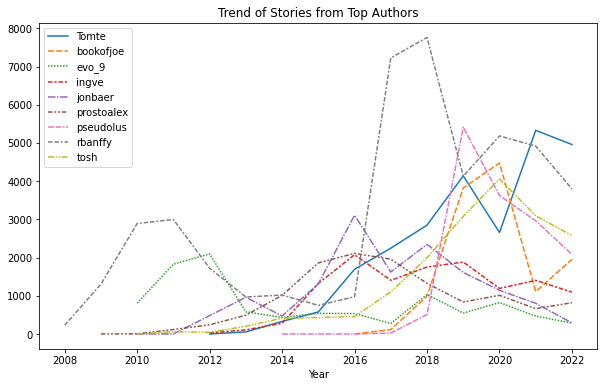

In [15]:
# Lets plot the results
plt.figure(figsize=(10,6))
plt.title("Trend of Stories from Top Authors")
sns.lineplot(data=wide_dat)

# 6. Authors with highest average score

In [16]:
# Authors with highest average score
query6 = """SELECT `by` AS Author, AVG (score) as Avg_Score
        FROM `bigquery-public-data.hacker_news.full` 
        WHERE type = 'story'
        GROUP BY Author
        ORDER BY Avg_score DESC
        LIMIT 10
"""
# Set up the query
query_job = client.query(query6)

# API request - run the query, and return a pandas DataFrame
Avg_score = query_job.to_dataframe()
Avg_score

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Author,Avg_Score
0,phantop,4240.0
1,fusl,2636.0
2,genedangelo,2634.0
3,megadeth,2595.0
4,fejkp,2585.0
5,rcoveson,2105.0
6,ews,2091.0
7,totablebanjo,2051.0
8,benhurmarcel,2023.0
9,lmueongoqx,2022.0


Text(0, 0.5, 'Average Score')

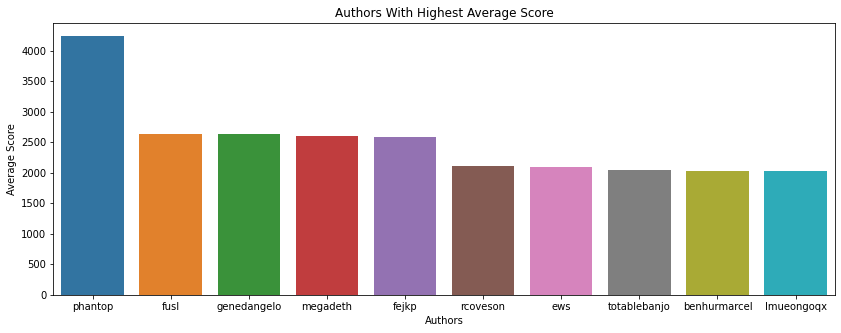

In [17]:
# Lets plot it
plt.figure(figsize=(14,5))
plt.title('Authors With Highest Average Score')
sns.barplot(x = Avg_score.Author, y=Avg_score.Avg_Score)
plt.xlabel("Authors")
plt.ylabel("Average Score")

# 7. Which date records the most number of stories

In [18]:
# Which date records the highest number of stories?
query7 = """
SELECT EXTRACT(DATE FROM `timestamp`) AS `Date`, COUNT(*) AS Num_stories
FROM `bigquery-public-data.hacker_news.full` 
WHERE type = 'story' AND `timestamp` IS NOT NULL
GROUP BY 1
ORDER BY Num_stories DESC
LIMIT 5
"""
# Set up the query
query_job = client.query(query7)

# API request - run the query, and return a pandas DataFrame
Most_stories_on = query_job.to_dataframe()
Most_stories_on

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Date,Num_stories
0,2020-05-19,1648
1,2020-05-28,1573
2,2020-05-20,1548
3,2020-05-26,1543
4,2020-03-31,1535


# Stories with most number of comments on 12 Dec 2012

In [19]:
# Number of stories written on 12 Dec 2012
query8 = """
SELECT COUNT(*) AS Num_stories
FROM `bigquery-public-data.hacker_news.full` 
WHERE type = 'story' AND EXTRACT(DATE FROM `timestamp`) = '2012-12-12'
"""
# Set up the query
query_job = client.query(query8)

# API request - run the query, and return a pandas DataFrame
Dec_12 = query_job.to_dataframe()
Dec_12

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Num_stories
0,1032


In [20]:
# Ten stories with most number of comments on 12 Dec 2012
query9 = """
             WITH c AS
            (
            SELECT parent, COUNT(*) as num_comments
            FROM `bigquery-public-data.hacker_news.comments` 
            GROUP BY parent
            )
            SELECT s.id as story_id, s.by, s.title, c.num_comments
            FROM `bigquery-public-data.hacker_news.stories` AS s
            LEFT JOIN c
            ON s.id = c.parent
            WHERE EXTRACT(DATE FROM s.time_ts) = '2012-12-12'
            ORDER BY c.num_comments DESC
            LIMIT 10
             """
# Set up the query
query_job = client.query(query9)

# API request - run the query, and return a pandas DataFrame
Stories_with_most_comments = query_job.to_dataframe()
Stories_with_most_comments

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,story_id,by,title,num_comments
0,4910022,eipi,Ask HN: How do you manage your one-man project?,52
1,4912712,barredo,Kickstarter backers ready class action lawsuit...,43
2,4912872,Swizec,Why founders shouldn't be the developers,38
3,4909784,nathanbarry,Show HN: Designing Web Applications,37
4,4910313,sethbannon,Google Zeitgeist 2012,32
5,4910212,jwhelton,"If you’re trying to hack/deface a website, don...",31
6,4910406,agconway,Prof. calls out student for cheating via Math ...,30
7,4912964,liamk,"Mona Lisa in 50 polygons, using a genetic algo...",26
8,4910814,adsahay,diary.io - should we build this?,26
9,4907830,aidanskinner,"Goodbye, Uploads",24
